# 1. 기본 설정

In [ ]:
# colab 환경에서 구글드라이브 연결

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm # 진행상황 알려주는 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [ ]:
%cd /content/drive/MyDrive/teamC/데이터/원본데이터

/content/drive/MyDrive/teamC/데이터/원본데이터


In [ ]:
!unzip -qq 'data.zip'

In [ ]:
%ls

academy.csv                            student_workbook_progress.csv
custom_workbook_problem.csv            student_workbook_revision.csv
data.zip                               student_workbook_scoring.csv
mathflat_dsl_테이블명세서_221020.xlsx  student_worksheet.csv
problem_concept.csv                    student_worksheet_scoring.csv
problem.csv                            teacher.csv
problem_curriculum_concept_cache.csv   workbook.csv
problem_curriculum.csv                 workbook_page.csv
public_workbook_problem.csv            workbook_problem.csv
school_workbook_problem.csv            worksheet.csv
student.csv                            worksheet_problem.csv
student_workbook.csv


## 데이터 로드

In [ ]:
# 일부 데이터 불러오기

student = pd.read_csv('./student.csv')
academy = pd.read_csv('./academy.csv')
# academy_log = pd.read_csv('./academy_log.csv')
student_worksheet = pd.read_csv('./student_worksheet.csv')
student_worksheet_scoring = pd.read_csv('./student_worksheet_scoring.csv')

# 2. 데이터 전처리
* 굳이 다시 돌릴 필요는 없다!
* 이미 전처리 후에 저장된 것을 '3. 분석'에서 다시 가져올 것임으로!

## academy_InProgress_365(academy)

학원 운영 기간(시스템에 등록된 시점부터 지금까지)

1. academy_InProgress

2. academy_InProgress_365 <- 365일이 넘은 학원만 추출!

['academy.id', 'academy.status', 'academy.create_datetime','academy.runway']

In [ ]:
# 정식으로 서비스를 사용중인 학원에 대해서
academy_InProgress = academy[academy['status'] == 'PAY_INPROGRESS']

# 학원이 시스템상에 처음으로 가입한 날짜가 없는 경우, 그 데이터(행)를 제거
academy_InProgress = academy_InProgress.dropna(subset=['create_datetime'], how='any', axis=0)
academy_InProgress = academy_InProgress.reset_index()

# csv에서 데이터프레임으로 가져오면, 자료형이 문자열의 형태임으로 datetime으로 자료형을 변경해준다.
academy_InProgress['create_datetime'] = pd.to_datetime(academy_InProgress['create_datetime'])

In [ ]:
# 변경된 academy라고 생각하면 된다.

academy_InProgress.head()

,index,Unnamed: 0,id,status,create_datetime,runway
0,3,3,D0004,PAY_INPROGRESS,2016-06-11,2352
1,6,6,D0007,PAY_INPROGRESS,2016-05-30,2364
2,21,21,D0022,PAY_INPROGRESS,2016-07-11,2322
3,32,32,D0033,PAY_INPROGRESS,2016-07-26,2307
4,38,38,D0039,PAY_INPROGRESS,2016-08-12,2290


In [ ]:
# 새로운 'runway'열을 추가한다.(0으로 세팅)

academy_InProgress['runway'] = 0

# 이 열의 경우에 '시스템 최초 가입을로부터 지금까지의 시간간격'을 의미한다. <- 구체적으로는 day차이 일 듯!
for i in range(len(academy_InProgress)):
  academy_InProgress['runway'][i] = int(str( pd.Timestamp.today() - academy_InProgress['create_datetime'][i] ).split()[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
# 사용할 열만 선택

academy_InProgress = academy_InProgress[['id', 'status', 'create_datetime','runway']]
academy_InProgress.head()

,id,status,create_datetime,runway
0,D0004,PAY_INPROGRESS,2016-06-11,2352
1,D0007,PAY_INPROGRESS,2016-05-30,2364
2,D0022,PAY_INPROGRESS,2016-07-11,2322
3,D0033,PAY_INPROGRESS,2016-07-26,2307
4,D0039,PAY_INPROGRESS,2016-08-12,2290


In [ ]:
# 시스템안에서 지금까지 사용되는 날짜가 365일 이상인 것만 추출한다.
# 이 데이터프레임을 'academy_InProgress_365'으로 정의한다.

academy_InProgress_365 = academy_InProgress[academy_InProgress['runway']>=365]
academy_InProgress_365 = academy_InProgress_365.sort_values(by = ['runway'])
academy_InProgress_365 = academy_InProgress_365.reset_index()
academy_InProgress_365 = academy_InProgress_365[['id', 'status', 'create_datetime','runway']]
academy_InProgress_365.columns = ['academy.id', 'academy.status', 'academy.create_datetime','academy.runway']

academy_InProgress_365.head()

,academy.id,academy.status,academy.create_datetime,academy.runway
0,D13717,PAY_INPROGRESS,2021-11-18 15:34:42,365
1,D13716,PAY_INPROGRESS,2021-11-18 15:02:36,365
2,D13714,PAY_INPROGRESS,2021-11-18 14:35:15,365
3,D13708,PAY_INPROGRESS,2021-11-18 10:55:38,365
4,D13696,PAY_INPROGRESS,2021-11-16 20:24:27,367


## student_current_3_3(student)

고3으로 제한해서 정보 추출

['student.id', 'student.academy_id', 'student.school_type', 'student.grade', 'student.status']

In [ ]:
# 고등학생(['school_type'] == 3)이고, 3학년(student['grade'] == 3)인 경우 <- 즉, 고3만 가져온다.

student_current_3_3 = student[(student['school_type'] == 3) & (student['grade'] == 3)]
student_current_3_3 = student_current_3_3[['id', 'academy_id', 'school_type', 'grade', 'status']]
student_current_3_3.columns = ['student.id', 'student.academy_id', 'student.school_type', 'student.grade', 'student.status']

student_current_3_3.head()

,student.id,student.academy_id,student.school_type,student.grade,student.status
0,I0,D0000,3,3,1
2,I10,D0000,3,3,1
3,I100,D0014,3,3,0
4,I1000,D0059,3,3,0
5,I10000,D0562,3,3,0


## 1. academy_student
***(academy + student)***

위의 academy_InProgress_365와 student_current_3_3를 결합

In [ ]:
academy_student = pd.merge(academy_InProgress_365, student_current_3_3, left_on='academy.id', right_on='student.academy_id', how='inner')
academy_student.head()

,academy.id,academy.status,academy.create_datetime,academy.runway,student.id,student.academy_id,student.school_type,student.grade,student.status
0,D13717,PAY_INPROGRESS,2021-11-18 15:34:42,365,I404615,D13717,3,3,2
1,D13717,PAY_INPROGRESS,2021-11-18 15:34:42,365,I419524,D13717,3,3,1
2,D13716,PAY_INPROGRESS,2021-11-18 15:02:36,365,I402567,D13716,3,3,1
3,D13716,PAY_INPROGRESS,2021-11-18 15:02:36,365,I402578,D13716,3,3,1
4,D13716,PAY_INPROGRESS,2021-11-18 15:02:36,365,I436186,D13716,3,3,0


## student_worksheet

In [ ]:
# 필요한 열들만 추출해서, 순서 바꾸고, 열이름도 바꿔주었다.

student_worksheet = student_worksheet[['id', 'worksheet_id', 'student_id', 'create_datetime','open_datetime', 'solve_datetime']]
student_worksheet.columns = ['s_ws.id', 's_ws.worksheet_id', 's_ws.student_id', 's_ws.create_datetime','s_ws.open_datetime', 's_ws.solve_datetime']

student_worksheet.head()

KeyError: ignored

In [ ]:
print('완료된 worksheet :', student_worksheet['s_ws.solve_datetime'].notnull().sum())
print('아직 완료되지 않은 worksheet :', student_worksheet['s_ws.solve_datetime'].isnull().sum())
print('전체 worksheet 수 :', student_worksheet.shape[0])

완료된 worksheet : 2131058
아직 완료되지 않은 worksheet : 2069050
전체 worksheet 수 : 4200108


## 2. academy_student_workwheet

***(academy + student + student_workwheet)***

이전의 academy_student와 student_workwheet를 합친다.

In [ ]:
academy_student_workwheet = pd.merge(academy_student, student_worksheet, left_on='student.id', right_on='s_ws.student_id', how='inner')
academy_student_workwheet.head()

,academy.id,academy.status,academy.create_datetime,academy.runway,student.id,student.academy_id,student.school_type,student.grade,student.status,s_ws.id,s_ws.worksheet_id,s_ws.student_id,s_ws.create_datetime,s_ws.open_datetime,s_ws.solve_datetime
0,D13717,PAY_INPROGRESS,2021-11-18 15:34:42,365,I404615,D13717,3,3,2,12759821,10576812,I404615,2021-11-28 17:18:51,2021-11-28 19:06:53,NaN
1,D13717,PAY_INPROGRESS,2021-11-18 15:34:42,365,I404615,D13717,3,3,2,13230425,11003219,I404615,2021-12-27 01:55:33,2021-12-30 16:52:51,2022-01-15 06:39:24
2,D13717,PAY_INPROGRESS,2021-11-18 15:34:42,365,I404615,D13717,3,3,2,13399883,11142071,I404615,2022-01-06 14:20:26,NaN,NaN
3,D13717,PAY_INPROGRESS,2021-11-18 15:34:42,365,I404615,D13717,3,3,2,13460573,11192877,I404615,2022-01-09 18:16:09,NaN,2022-01-15 20:35:23
4,D13717,PAY_INPROGRESS,2021-11-18 15:34:42,365,I404615,D13717,3,3,2,13460598,11192884,I404615,2022-01-09 18:17:10,NaN,NaN


In [ ]:
## 저장하는 코드

# academy_student_workwheet.to_csv('/content/drive/MyDrive/teamC/Namhun/academy_student_workwheet.csv')

## dummy

academy_student_workwheet에서 ws가 풀리지 않은 것들을 제거한 데이터

In [ ]:
# NULL값 때문에 계산이 안된다. <- NULL값들을 제거해주어야한다.

print(min(pd.to_datetime(academy_student_workwheet['s_ws.solve_datetime'])))
print(max(pd.to_datetime(academy_student_workwheet['s_ws.solve_datetime'])))

In [ ]:
# ws가 풀리지 않은 것들을 제거한 데이터; dummy

dummy = academy_student_workwheet.dropna(subset=['s_ws.solve_datetime'], how='any', axis=0)

print(min(pd.to_datetime(dummy['s_ws.solve_datetime']))) # 가장 먼저 푼 날짜
print(max(pd.to_datetime(dummy['s_ws.solve_datetime']))) # 가장 나중에 푼 날짜

2016-12-13 16:20:27
2022-10-14 02:58:00


In [ ]:
academy_student_workwheet.shape

(802362, 15)

In [ ]:
dummy.shape

(412646, 15)

## student_worksheet_scoring

In [ ]:
student_worksheet_scoring.head()

,Unnamed: 0,id,student_worksheet_id,worksheet_problem_id,result,update_datetime
0,0,22673,6915137,146873314,CORRECT,2020-10-25 15:08:06
1,1,22674,6915137,146873315,WRONG,2020-10-25 15:08:06
2,2,22675,6915137,146873316,WRONG,2020-10-25 15:08:06
3,3,22676,6915137,146873317,WRONG,2020-10-25 15:08:06
4,4,22677,6915137,146873318,WRONG,2020-10-25 15:08:06


In [ ]:
# 2000년 데이터가 있다는 것이 조금 이상하다.
# 특히, 나중에 student와 merge를 하게 된다면... 2000년과 2020년도에 같은 학생id가 발견된다는게 더욱 수상한데...

student_worksheet_scoring.update_datetime.apply(lambda x: int(x.split()[0].split('-')[0])).value_counts()

2022    36785312
2017    33949532
2021    20199285
2020     3578857
2000        2293
Name: update_datetime, dtype: int64

In [ ]:
# 필요한 열들만 추출해서, 순서 바꾸고, 열이름도 바꿔주었다.

student_worksheet_scoring = student_worksheet_scoring[['id', 'student_worksheet_id', 'worksheet_problem_id', 'result', 'update_datetime']]
student_worksheet_scoring.columns = ['ws_scoring.id', 'ws_scoring.student_worksheet_id', 'ws_scoring.worksheet_problem_id', 'ws_scoring.result', 'ws_scoring.update_datetime']

student_worksheet_scoring.head()

,ws_scoring.id,ws_scoring.student_worksheet_id,ws_scoring.worksheet_problem_id,ws_scoring.result,ws_scoring.update_datetime
0,22673,6915137,146873314,CORRECT,2020-10-25 15:08:06
1,22674,6915137,146873315,WRONG,2020-10-25 15:08:06
2,22675,6915137,146873316,WRONG,2020-10-25 15:08:06
3,22676,6915137,146873317,WRONG,2020-10-25 15:08:06
4,22677,6915137,146873318,WRONG,2020-10-25 15:08:06


In [ ]:
# 문제의 채점결과가 맞거나 틀린 걸로 되어있는 것들만 추출 <- 즉, result가 NULL인 것들만 제외

student_worksheet_scoring = student_worksheet_scoring[(student_worksheet_scoring['ws_scoring.result'] == 'CORRECT') | (student_worksheet_scoring['ws_scoring.result'] == 'WRONG') ]
student_worksheet_scoring.head()

,ws_scoring.id,ws_scoring.student_worksheet_id,ws_scoring.worksheet_problem_id,ws_scoring.result,ws_scoring.update_datetime
0,22673,6915137,146873314,CORRECT,2020-10-25 15:08:06
1,22674,6915137,146873315,WRONG,2020-10-25 15:08:06
2,22675,6915137,146873316,WRONG,2020-10-25 15:08:06
3,22676,6915137,146873317,WRONG,2020-10-25 15:08:06
4,22677,6915137,146873318,WRONG,2020-10-25 15:08:06


In [ ]:
# NULL의 갯수

student_worksheet_scoring.loc[:,'ws_scoring.result'].isnull().sum()

0

In [ ]:
# # 저장

# student_worksheet_scoring.to_csv('/content/drive/MyDrive/teamC/Namhun/student_worksheet_scoring.csv')
# academy_student.to_csv('/content/drive/MyDrive/teamC/Namhun/academy_student.csv')

## 3. academy_student_workwheet_scoring

***(academy + student + student_workwheet + student_worksheet_scoring)***

방금 만든 'student_worksheet_scoring'와 이전에 만든 'academy_student_workwheet'를 합친다.

In [ ]:
academy_student_workwheet_scoring = pd.merge(student_worksheet_scoring, academy_student_workwheet,
                                             left_on='ws_scoring.student_worksheet_id', right_on='s_ws.id', how='inner')

academy_student_workwheet_scoring = academy_student_workwheet_scoring[['academy.id', 'academy.status', 'academy.create_datetime', 'academy.runway', 
                                                                       'student.id', 'student.school_type', 'student.grade', 'student.status', 
                                                                       's_ws.id', 's_ws.worksheet_id','s_ws.create_datetime', 's_ws.open_datetime', 's_ws.solve_datetime',
                                                                       'ws_scoring.id', 'ws_scoring.worksheet_problem_id', 'ws_scoring.result', 'ws_scoring.update_datetime']]
academy_student_workwheet_scoring.head()                                                           

,academy.id,academy.status,academy.create_datetime,academy.runway,student.id,student.school_type,student.grade,student.status,s_ws.id,s_ws.worksheet_id,s_ws.create_datetime,s_ws.open_datetime,s_ws.solve_datetime,ws_scoring.id,ws_scoring.worksheet_problem_id,ws_scoring.result,ws_scoring.update_datetime
0,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6915137,5525992,2020-10-13 18:33:06,NaN,2020-10-25 15:08:06,22673,146873314,CORRECT,2020-10-25 15:08:06
1,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6915137,5525992,2020-10-13 18:33:06,NaN,2020-10-25 15:08:06,22674,146873315,WRONG,2020-10-25 15:08:06
2,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6915137,5525992,2020-10-13 18:33:06,NaN,2020-10-25 15:08:06,22675,146873316,WRONG,2020-10-25 15:08:06
3,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6915137,5525992,2020-10-13 18:33:06,NaN,2020-10-25 15:08:06,22676,146873317,WRONG,2020-10-25 15:08:06
4,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6915137,5525992,2020-10-13 18:33:06,NaN,2020-10-25 15:08:06,22677,146873318,WRONG,2020-10-25 15:08:06


In [ ]:
# # 최종 결과를 저장

# academy_student_workwheet_scoring.to_csv('/content/drive/MyDrive/teamC/Namhun/academy_student_workwheet_scoring.csv')

## ws_problem(worksheet_problem)

In [ ]:
ws_problem = pd.read_csv('/content/drive/MyDrive/archive/sql_2_csv/worksheet_problem.csv')
ws_problem.head()

,Unnamed: 0,id,worksheet_id,problem_id,ordering_number,type
0,0,10995922,500537,12383,15,0
1,1,13061201,594987,12383,20,0
2,2,15119058,677340,12383,43,0
3,3,16749852,752441,13267,20,0
4,4,18470988,819674,13238,28,0


In [ ]:
# 필요한 열들만 추출해서, 순서 바꾸고, 열이름도 바꿔주었다.

ws_problem = ws_problem[['id', 'worksheet_id', 'problem_id', 'ordering_number','type']]
ws_problem.columns = ['ws_problem.id', 'ws_problem.worksheet_id', 'ws_problem.problem_id', 'ws_problem.ordering_number','ws_problem.type']
ws_problem.head()

,ws_problem.id,ws_problem.worksheet_id,ws_problem.problem_id,ws_problem.ordering_number,ws_problem.type
0,10995922,500537,12383,15,0
1,13061201,594987,12383,20,0
2,15119058,677340,12383,43,0
3,16749852,752441,13267,20,0
4,18470988,819674,13238,28,0


## 4. academy_student_workwheet_scoring_problem

***(academy + student + student_workwheet + student_worksheet_scoring + worksheet_problem)***

'academy_student_workwheet_scoring'이랑 'ws_problem'를 합친다.

사실, worksheet도 연관이 되어 있는데, 이것은 일단 고려하지 않고 수행해준다.

In [ ]:
academy_student_workwheet_scoring_problem = pd.merge(academy_student_workwheet_scoring, ws_problem,
                                                     left_on='ws_scoring.worksheet_problem_id', right_on='ws_problem.id', how='inner')
academy_student_workwheet_scoring_problem = academy_student_workwheet_scoring_problem[['academy.id', 'academy.status', 'academy.create_datetime', 'academy.runway', 
                                                                       'student.id', 'student.school_type', 'student.grade', 'student.status', 
                                                                       's_ws.id', 's_ws.worksheet_id','s_ws.create_datetime', 's_ws.open_datetime', 's_ws.solve_datetime',
                                                                       'ws_scoring.id', 'ws_scoring.result', 'ws_scoring.update_datetime',
                                                                       'ws_problem.id', 'ws_problem.worksheet_id', 'ws_problem.problem_id', 'ws_problem.ordering_number','ws_problem.type']]
academy_student_workwheet_scoring_problem.head()

,academy.id,academy.status,academy.create_datetime,academy.runway,student.id,student.school_type,student.grade,student.status,s_ws.id,s_ws.worksheet_id,...,s_ws.open_datetime,s_ws.solve_datetime,ws_scoring.id,ws_scoring.result,ws_scoring.update_datetime,ws_problem.id,ws_problem.worksheet_id,ws_problem.problem_id,ws_problem.ordering_number,ws_problem.type
0,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6915137,5525992,...,NaN,2020-10-25 15:08:06,22673,CORRECT,2020-10-25 15:08:06,146873314,5525992,252454,1,0
1,D0409,PAY_INPROGRESS,2017-03-02,2088,I7983,3,3,0,6915136,5525992,...,NaN,2020-10-25 15:12:47,83242,CORRECT,2020-10-25 15:12:47,146873314,5525992,252454,1,0
2,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6915137,5525992,...,NaN,2020-10-25 15:08:06,22674,WRONG,2020-10-25 15:08:06,146873315,5525992,252438,2,0
3,D0409,PAY_INPROGRESS,2017-03-02,2088,I7983,3,3,0,6915136,5525992,...,NaN,2020-10-25 15:12:47,83243,CORRECT,2020-10-25 15:12:47,146873315,5525992,252438,2,0
4,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6915137,5525992,...,NaN,2020-10-25 15:08:06,22675,WRONG,2020-10-25 15:08:06,146873316,5525992,252484,3,0


In [ ]:
# # 결과 저장

# academy_student_workwheet_scoring_problem.to_csv('/content/drive/MyDrive/teamC/Namhun/academy_student_workwheet_scoring_problem.csv')

### date, year 열 추가

ws_scoring.update_datetime열이 조금 복잡하게 되어 있어서, 아래와 같이 데이터가 나오도록 했다.
* date = 날짜
* year = 연도


In [ ]:
academy_student_workwheet_scoring_problem.loc[:,'ws_scoring.update_datetime'].head()

0    2020-10-25 15:08:06
1    2020-10-25 15:12:47
2    2020-10-25 15:08:06
3    2020-10-25 15:12:47
4    2020-10-25 15:08:06
Name: ws_scoring.update_datetime, dtype: object

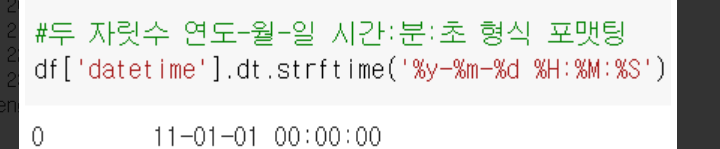

In [ ]:
pd.to_datetime(academy_student_workwheet_scoring_problem['ws_scoring.update_datetime']).dt.strftime('%y-%m-%d').head()

0    20-10-25
1    20-10-25
2    20-10-25
3    20-10-25
4    20-10-25
Name: ws_scoring.update_datetime, dtype: object

In [ ]:
# ws_scoring.update_datetime열이 조금 복잡하게 되어 있어서, 아래와 같이 데이터가 나오도록 했다.
# date = 날짜
# year = 연도

academy_student_workwheet_scoring_problem['date'] = pd.to_datetime(academy_student_workwheet_scoring_problem['ws_scoring.update_datetime']).dt.strftime('%y-%m-%d')
academy_student_workwheet_scoring_problem['year'] = pd.to_datetime(academy_student_workwheet_scoring_problem['ws_scoring.update_datetime']).dt.year

academy_student_workwheet_scoring_problem.loc[:,['ws_scoring.update_datetime', 'date', 'year']].head()

,ws_scoring.update_datetime,date,year
0,2020-10-25 15:08:06,20-10-25,2020
1,2020-10-25 15:12:47,20-10-25,2020
2,2020-10-25 15:08:06,20-10-25,2020
3,2020-10-25 15:12:47,20-10-25,2020
4,2020-10-25 15:08:06,20-10-25,2020


### recorded_grade열 추가

일단 년도의 경우에 2000, 2020, 2021, 2022로만 나오는데, 이 자체도 이상하다.

그리고 recorded_grade는 4로 나눈 나머지를 의미하기에 무엇을 나타내는 값인지는 잘 모르곘다.

In [ ]:
academy_student_workwheet_scoring_problem['recorded_grade'] = 0

academy_student_workwheet_scoring_problem['recorded_grade'] = academy_student_workwheet_scoring_problem['year'].apply(lambda x:x%4+1)
academy_student_workwheet_scoring_problem.loc[:,'recorded_grade'].value_counts()

2    6310791
3    1962496
1    1793513
Name: recorded_grade, dtype: int64

In [ ]:
academy_student_workwheet_scoring_problem['year'].value_counts()

2021    6310791
2022    1962496
2020    1792835
2000        678
Name: year, dtype: int64

In [ ]:
# # 저장

# academy_student_workwheet_scoring_problem.to_csv('/content/drive/MyDrive/teamC/Namhun/academy_student_workwheet_scoring_problem.csv')

In [ ]:
# raw 데이터인 'student_worksheet_scoring'를 직접 처리해보아도,
# 똑같이 2000, 2020, 2021, 2022만 데이터가 있다.

student_worksheet_scoring.loc[:,'ws_scoring.update_datetime'].apply(lambda x : int(x.split()[0].split('-')[0])).value_counts()

2022    21922427
2021    20147119
2020     3574757
2000        2082
Name: ws_scoring.update_datetime, dtype: int64

## problem

In [ ]:
# problem 테이블과 관련되서 필요한 것들을 모두 가져왔다.

problem = pd.read_csv('/content/drive/MyDrive/archive/sql_2_csv/problem.csv')
problem_concept = pd.read_csv('/content/drive/MyDrive/archive/sql_2_csv/problem_concept.csv')
problem_curriculum = pd.read_csv('/content/drive/MyDrive/archive/sql_2_csv/problem_curriculum.csv')
problem_curriculum_concept_cache = pd.read_csv('/content/drive/MyDrive/archive/sql_2_csv/problem_curriculum_concept_cache.csv')

In [ ]:
# 필요한 열들만 추출해서, 순서 바꾸고, 열이름도 바꿔주었다.

problem = problem[['id', 'problem_concept_id', 'group_code', 'level', 'type', 'correct_rate', 'create_datetime', 'update_datetime']]
problem.columns = ['p.id', 'p.problem_concept_id', 'p.group_code', 'p.level', 'p.type', 'p.correct_rate', 'p.create_datetime', 'p.update_datetime']
problem.head()

,p.id,p.problem_concept_id,p.group_code,p.level,p.type,p.correct_rate,p.create_datetime,p.update_datetime
0,1,1693,NaN,4,0,90.6250,2021-10-26 00:21:06,2022-07-13 12:30:47
1,2,1696,NaN,2,1,47.2868,2021-10-26 00:21:06,2022-09-20 11:23:31
2,3,1693,NaN,2,2,87.7953,2021-10-26 00:21:06,2022-09-20 11:24:16
3,4,1693,NaN,2,0,93.2990,2021-10-26 00:21:06,2022-09-20 11:24:16
4,5,1696,NaN,2,2,89.2473,2021-10-26 00:21:06,2022-09-20 11:24:16


## 5. academy_student_workwheet_scoring_problem_problem

***(academy + student + student_workwheet + student_worksheet_scoring + worksheet_problem + problem)***

'academy_student_workwheet_scoring_problem'이랑 'problem'를 합친다.

In [ ]:
academy_student_workwheet_scoring_problem_problem = pd.merge(academy_student_workwheet_scoring_problem, problem,
                                                             left_on='ws_problem.problem_id', right_on='p.id', how='inner')

academy_student_workwheet_scoring_problem_problem = academy_student_workwheet_scoring_problem_problem[['academy.id', 'academy.status', 'academy.create_datetime', 'academy.runway', 
                                                                       'student.id', 'student.school_type', 'student.grade', 'student.status', 
                                                                       's_ws.id', 's_ws.worksheet_id','s_ws.create_datetime', 's_ws.open_datetime', 's_ws.solve_datetime',
                                                                       'ws_scoring.id', 'ws_scoring.result', 'ws_scoring.update_datetime',
                                                                       'ws_problem.id', 'ws_problem.worksheet_id', 'ws_problem.problem_id', 'ws_problem.ordering_number','ws_problem.type',
                                                                       'date', 'year',
                                                                       'p.id', 'p.problem_concept_id', 'p.group_code', 'p.level', 'p.type', 'p.correct_rate', 'p.create_datetime', 'p.update_datetime']]
academy_student_workwheet_scoring_problem_problem.head()

In [ ]:
academy_student_workwheet_scoring_problem_problem.sort_values(by=['student.id', 'year']).head()

In [ ]:
# 저장

academy_student_workwheet_scoring_problem_problem.to_csv('/content/drive/MyDrive/teamC/Namhun/academy_student_workwheet_scoring_problem_problem.csv')

## problem concept

In [ ]:
# 필요한 열들만 추출해서, 순서 바꾸고, 열이름도 바꿔주었다.

problem_concept = problem_concept[['id', 'problem_curriculum_id', 'school', 'grade','semester', 'name', 'sequence', 'correct_rate', 'create_datetime','update_datetime']]
problem_concept.columns = ['p_cpt.id', 'p_cpt.problem_curriculum_id', 'p_cpt.school', 'p_cpt.grade','p_cpt.semester', 'p_cpt.name', 'p_cpt.sequence', 'p_cpt.correct_rate', 'p_cpt.create_datetime','p_cpt.update_datetime']
problem_concept.head()


,p_cpt.id,p_cpt.problem_curriculum_id,p_cpt.school,p_cpt.grade,p_cpt.semester,p_cpt.name,p_cpt.sequence,p_cpt.correct_rate,p_cpt.create_datetime,p_cpt.update_datetime
0,1,1,1,1,1,미분류,1,65.9813,2021-10-26 00:20:37,2021-10-26 00:20:37
1,2,2415,2,1,2,줄기와 잎 정하기,1,88.5755,2021-10-26 00:20:38,2021-10-26 00:20:38
2,3,2415,2,1,2,자료의 최고와 최저 구하기,2,90.8241,2021-10-26 00:20:38,2021-10-26 00:20:38
3,4,2415,2,1,2,줄기와 잎그림에서 조건에 맞게 빈칸 채우기,3,84.9490,2021-10-26 00:20:38,2021-10-26 00:20:38
4,5,2415,2,1,2,특정 줄기의 잎 찾기,4,94.4262,2021-10-26 00:20:38,2021-10-26 00:20:38


## 6. academy_student_workwheet_scoring_problem_problem_cpt

***(academy + student + student_workwheet + student_worksheet_scoring + worksheet_problem + problem + problem_concept)***

'academy_student_workwheet_scoring_problem_problem'이랑 'problem_concept'를 합친다.

In [ ]:
academy_student_workwheet_scoring_problem_problem_cpt = pd.merge(academy_student_workwheet_scoring_problem_problem, problem_concept,
                                                                 left_on='p.problem_concept_id', right_on='p_cpt.id', how='inner')
academy_student_workwheet_scoring_problem_problem_cpt = academy_student_workwheet_scoring_problem_problem_cpt[['academy.id', 'academy.status', 'academy.create_datetime', 'academy.runway', 
                                                                       'student.id', 'student.school_type', 'student.grade', 'student.status', 
                                                                       's_ws.id', 's_ws.worksheet_id','s_ws.create_datetime', 's_ws.open_datetime', 's_ws.solve_datetime',
                                                                       'ws_scoring.id', 'ws_scoring.result', 'ws_scoring.update_datetime',
                                                                       'ws_problem.id', 'ws_problem.worksheet_id', 'ws_problem.problem_id', 'ws_problem.ordering_number','ws_problem.type',
                                                                       'date', 'year',
                                                                       'p.id',  'p.group_code', 'p.level', 'p.type', 'p.correct_rate', 'p.create_datetime', 'p.update_datetime',
                                                                       'p_cpt.id', 'p_cpt.problem_curriculum_id', 'p_cpt.school', 'p_cpt.grade','p_cpt.semester', 'p_cpt.name', 'p_cpt.sequence', 'p_cpt.correct_rate', 'p_cpt.create_datetime','p_cpt.update_datetime']]
academy_student_workwheet_scoring_problem_problem_cpt.head()

,academy.id,academy.status,academy.create_datetime,academy.runway,student.id,student.school_type,student.grade,student.status,s_ws.id,s_ws.worksheet_id,...,p_cpt.id,p_cpt.problem_curriculum_id,p_cpt.school,p_cpt.grade,p_cpt.semester,p_cpt.name,p_cpt.sequence,p_cpt.correct_rate,p_cpt.create_datetime,p_cpt.update_datetime
0,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6915137,5525992,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
1,D0409,PAY_INPROGRESS,2017-03-02,2088,I7983,3,3,0,6915136,5525992,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
2,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6931764,5540742,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
3,D0409,PAY_INPROGRESS,2017-03-02,2088,I7983,3,3,0,6931761,5540742,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
4,D0409,PAY_INPROGRESS,2017-03-02,2088,I15492,3,3,1,6931765,5540742,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39


In [ ]:
# # 저장

# academy_student_workwheet_scoring_problem_problem_cpt.to_csv('/content/drive/MyDrive/teamC/Namhun/academy_student_workwheet_scoring_problem_problem_cpt.csv')

# 3. 분석

## (전처리) 집계

In [ ]:
# 최종 데이터 불러오기
# 내가 만든 데이터

path = '/Users/namhunkim/Downloads/DSL/프리윌린/teamC/데이터/academy_student_workwheet_scoring_problem_problem_cpt.csv'
data = pd.read_csv(path)
data.head()

,Unnamed: 0,academy.id,academy.status,academy.create_datetime,academy.runway,student.id,student.school_type,student.grade,student.status,s_ws.id,...,p_cpt.id,p_cpt.problem_curriculum_id,p_cpt.school,p_cpt.grade,p_cpt.semester,p_cpt.name,p_cpt.sequence,p_cpt.correct_rate,p_cpt.create_datetime,p_cpt.update_datetime
0,0,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6915137,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
1,1,D0409,PAY_INPROGRESS,2017-03-02,2088,I7983,3,3,0,6915136,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
2,2,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6931764,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
3,3,D0409,PAY_INPROGRESS,2017-03-02,2088,I7983,3,3,0,6931761,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
4,4,D0409,PAY_INPROGRESS,2017-03-02,2088,I15492,3,3,1,6931765,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39


In [ ]:
data.columns

Index(['Unnamed: 0', 'academy.id', 'academy.status', 'academy.create_datetime',
       'academy.runway', 'student.id', 'student.school_type', 'student.grade',
       'student.status', 's_ws.id', 's_ws.worksheet_id',
       's_ws.create_datetime', 's_ws.open_datetime', 's_ws.solve_datetime',
       'ws_scoring.id', 'ws_scoring.result', 'ws_scoring.update_datetime',
       'ws_problem.id', 'ws_problem.worksheet_id', 'ws_problem.problem_id',
       'ws_problem.ordering_number', 'ws_problem.type', 'date', 'year', 'p.id',
       'p.group_code', 'p.level', 'p.type', 'p.correct_rate',
       'p.create_datetime', 'p.update_datetime', 'p_cpt.id',
       'p_cpt.problem_curriculum_id', 'p_cpt.school', 'p_cpt.grade',
       'p_cpt.semester', 'p_cpt.name', 'p_cpt.sequence', 'p_cpt.correct_rate',
       'p_cpt.create_datetime', 'p_cpt.update_datetime'],
      dtype='object')

In [ ]:
# 팔요없는 열 삭제

remove_col = ['Unnamed: 0', 'academy.status', 'student.school_type', 'student.grade']

data = data.drop(remove_col, axis=1)
data.shape

(10066800, 37)

## 1. 데이터 집단 줄이기

In [ ]:
# 여기에 줄인 데이터를 저장할 것이다.

data_imp = data
data_imp.head(1)

,academy.id,academy.create_datetime,academy.runway,student.id,student.status,s_ws.id,s_ws.worksheet_id,s_ws.create_datetime,s_ws.open_datetime,s_ws.solve_datetime,...,p_cpt.id,p_cpt.problem_curriculum_id,p_cpt.school,p_cpt.grade,p_cpt.semester,p_cpt.name,p_cpt.sequence,p_cpt.correct_rate,p_cpt.create_datetime,p_cpt.update_datetime
0,D0409,2017-03-02,2088,I7951,1,6915137,5525992,2020-10-13 18:33:06,NaN,2020-10-25 15:08:06,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39


### worksheet를 몇 개 이상 푼 학생만 선택

In [ ]:
data_temp = data.loc[:, ['student.id', 's_ws.worksheet_id']]
data_temp.columns = ['student_id', 'worksheet_id']
data_temp.head(1)

,student_id,worksheet_id
0,I7951,5525992


In [ ]:
# 각 학생이 몇 개의 worksheet를 풀었는가?

data_temp.groupby('student_id').worksheet_id.count()

student_id
I100008    5352
I100067    4366
I100168    5854
I100268     370
I100300     366
           ... 
I99938       20
I99963      110
IB113        88
IB123       283
IB163       272
Name: worksheet_id, Length: 15991, dtype: int64

In [ ]:
# 각 학생이 푼 worksheet 갯수의 분포

data_temp.groupby('student_id').worksheet_id.count().value_counts()

30      306
20      297
50      236
25      232
60      147
       ... 
1951      1
2600      1
1768      1
3411      1
3419      1
Name: worksheet_id, Length: 2772, dtype: int64

In [ ]:
# index = 푼 worksheet수
# value = 해당 되는 worksheet갯수만큼 푼 학생수

data_temp.groupby('student_id').worksheet_id.count().value_counts().sort_index()[:40]

# 결론
# - 대충 20번 푼 사람부터 많이 나타나기 시작하니, n=20으로 잡고
# - 이보다 적게 푼 사람은 버리자.

1      23
2      18
3      22
4      18
5      38
6      23
7      35
8      43
9      28
10     92
11     20
12     32
13     33
14     19
15     74
16     31
17     30
18     40
19     36
20    297
21     37
22     49
23     29
24    104
25    232
26     37
27     71
28     37
29     31
30    306
31     33
32     33
33     36
34     39
35     43
36     42
37     32
38     34
39     34
40    147
Name: worksheet_id, dtype: int64

In [ ]:
# 이제 여기서 worksheet_id가 20이상인 것들을 선택하자.

data_temp.groupby('student_id').count()

,worksheet_id
student_id,
I100008,5352
I100067,4366
I100168,5854
I100268,370
I100300,366
...,...
I99938,20
I99963,110
IB113,88


In [ ]:
# student_id
st_id = data_temp.groupby('student_id').count().index.values

# 20 이상인 것의 index
idx = ( data_temp.groupby('student_id').count() >= 20 ).values.flatten()

# 20 이상인 student_id
want_st_id1 = st_id[idx]
want_st_id1

array(['I100008', 'I100067', 'I100168', ..., 'IB113', 'IB123', 'IB163'],
      dtype=object)

### 시스템 안에서 어느 기간 동안에 머문 학생들만 추출

In [ ]:
data_temp = data.loc[:, ['student.id', 'ws_scoring.update_datetime']]
data_temp.columns = ['student_id', 'solve_date']

# 하루 안에서 시간이 다르기도 하나, 큰 문제가 안될 것임으로 '년도-월-일'만 고려
data_temp.loc[:,'solve_date'] = data_temp.loc[:,'solve_date'].apply(lambda x : x.split()[0])
data_temp.head(1)

,student_id,solve_date
0,I7951,2020-10-25


In [ ]:
# 확인해보면, (2000, 2020,2021,2022)년 데이터가 있는데
# 2000년의 solve_date의 경우에 다른 년도와 다른 학생임으로
# 간단하게 2000년 데이터를 제거해주면 된다.

idx = ( data_temp.loc[:, 'solve_date'].apply(lambda x : x.split('-')[0]) != '2000' )
data_temp = data_temp[idx]
data_temp

,student_id,solve_date
0,I7951,2020-10-25
1,I7983,2020-10-25
2,I7951,2020-10-15
3,I7983,2020-10-15
4,I15492,2020-10-21
...,...,...
10066795,I342262,2022-03-15
10066796,I342262,2022-03-15
10066797,I438579,2022-03-02
10066798,I203077,2022-03-12


In [ ]:
# 'solve_date'열의 데이터형태를 string -> datetime 으로 변경

data_temp.loc[:, 'solve_date'] = pd.to_datetime(data_temp['solve_date'])
data_temp.head(1)

,student_id,solve_date
0,I7951,2020-10-25


In [ ]:
# 학생별 가장 처음 worksheet를 푼 날짜(min)과 가장 마지막으로 worksheet를 푼 날짜(max)

temp = data_temp.groupby('student_id').solve_date.agg(['min', 'max'])
temp

,min,max
student_id,,
I100008,2020-11-07,2021-11-18
I100067,2020-10-10,2022-04-18
I100168,2020-10-10,2021-06-25
I100268,2021-01-11,2021-03-14
I100300,2020-10-07,2020-12-06
...,...,...
I99938,2021-01-16,2021-01-16
I99963,2020-10-09,2021-02-26
IB113,2020-12-04,2021-03-19


In [ ]:
# 시스템 상에서 머문 시간(일수)

day_diff = temp.loc[:,'max'] - temp.loc[:,'min']
day_diff

student_id
I100008   376 days
I100067   555 days
I100168   258 days
I100268    62 days
I100300    60 days
            ...   
I99938      0 days
I99963    140 days
IB113     105 days
IB123      40 days
IB163       0 days
Length: 15991, dtype: timedelta64[ns]

In [ ]:
# 머문 일수에 대한 각 학생수

day_diff.value_counts().sort_index()

0 days      2491
1 days       103
2 days       152
3 days       109
4 days       126
            ... 
737 days       4
738 days       3
739 days       4
740 days       1
741 days       1
Length: 718, dtype: int64

In [ ]:
# '0일'만 머문 사람이 제일 많았고,
# 제일 오래 머문 사람은 '741일 = 대략 2년'이다.
# 각 데이터를 살펴보고자 50씩 쪼개서 확인해보는데, 재미있는게 발견되었다.
# 그건 7의 배수 날 동안 머문 사람이 많은 것이다. (즉, 1주일 간격으로 사람들이 머문다고 볼 수 있다.) <- 왜인지는 모르겠다.
# 특히, 대략 '63일'까지는 7의 배수 날과 다른 날과의 차이가 많이 심하다.
# 따라서 그냥 근거없이 '63일'보다는 더 긴 3개월(90일) 이상 머문 학생만 선택하기로 한다.

day_diff.value_counts().sort_index()[:50]

0 days     2491
1 days      103
2 days      152
3 days      109
4 days      126
5 days      117
6 days       87
7 days      326
8 days       98
9 days       92
10 days     102
11 days      93
12 days      96
13 days      56
14 days     226
15 days      84
16 days      75
17 days      75
18 days      90
19 days      81
20 days      60
21 days     238
22 days      75
23 days      67
24 days      80
25 days      59
26 days      68
27 days      39
28 days     180
29 days      52
30 days      79
31 days      64
32 days      51
33 days      75
34 days      42
35 days     155
36 days      46
37 days      59
38 days      62
39 days      56
40 days      53
41 days      29
42 days     177
43 days      50
44 days      64
45 days      42
46 days      43
47 days      49
48 days      53
49 days     165
dtype: int64

In [ ]:
day_diff.value_counts().sort_index()[50:101]

50 days      51
51 days      38
52 days      47
53 days      66
54 days      46
55 days      41
56 days     135
57 days      36
58 days      60
59 days      52
60 days      65
61 days      58
62 days      37
63 days     106
64 days      52
65 days      48
66 days      36
67 days      38
68 days      43
69 days      34
70 days      68
71 days      36
72 days      44
73 days      51
74 days      47
75 days      30
76 days      29
77 days      69
78 days      36
79 days      46
80 days      35
81 days      31
82 days      34
83 days      23
84 days      69
85 days      26
86 days      41
87 days      27
88 days      32
89 days      42
90 days      31
91 days      54
92 days      32
93 days      32
94 days      25
95 days      30
96 days      32
97 days      29
98 days      57
99 days      20
100 days     46
dtype: int64

In [ ]:
day_diff.value_counts().sort_index()[100:151]

100 days    46
101 days    26
102 days    24
103 days    32
104 days    25
105 days    64
106 days    25
107 days    22
108 days    16
109 days    26
110 days    25
111 days    18
112 days    50
113 days    18
114 days    36
115 days    19
116 days    33
117 days    18
118 days    23
119 days    35
120 days    25
121 days    28
122 days    23
123 days    16
124 days    28
125 days    28
126 days    64
127 days    22
128 days    35
129 days    20
130 days    18
131 days    31
132 days    27
133 days    63
134 days    31
135 days    25
136 days    27
137 days    28
138 days    29
139 days    34
140 days    46
141 days    24
142 days    24
143 days    28
144 days    32
145 days    30
146 days    19
147 days    44
148 days    31
149 days    21
150 days    32
dtype: int64

In [ ]:
day_diff.value_counts().sort_index()[150:201]

150 days    32
151 days    23
152 days    29
153 days    18
154 days    57
155 days    21
156 days    22
157 days    37
158 days    22
159 days    26
160 days    23
161 days    47
162 days    21
163 days    18
164 days    19
165 days    18
166 days    19
167 days    23
168 days    58
169 days    17
170 days    29
171 days    22
172 days    14
173 days    24
174 days    22
175 days    32
176 days    27
177 days    31
178 days    20
179 days    19
180 days    24
181 days    14
182 days    30
183 days    18
184 days    22
185 days    15
186 days    11
187 days    13
188 days     9
189 days    31
190 days    19
191 days    26
192 days    17
193 days    23
194 days    15
195 days    16
196 days    42
197 days    17
198 days    18
199 days    22
200 days    30
dtype: int64

In [ ]:
# 90일 이상 머문 student_id

idx = (day_diff.apply(lambda x : x.days) >= 90).values
want_st_id2 = day_diff.index.values[idx]
want_st_id2

array(['I100008', 'I100067', 'I100168', ..., 'I99874', 'I99963', 'IB113'],
      dtype=object)

### 최종적으로 이용할 데이터 선택

In [ ]:
# 두 학생id의 교집합을 선택한다.

want_st_final = np.intersect1d(want_st_id1, want_st_id2)
want_st_final

array(['I100008', 'I100067', 'I100168', ..., 'I99874', 'I99963', 'IB113'],
      dtype=object)

In [ ]:
# 사용할 학생수; 7072

len(want_st_final)

7072

In [ ]:
# 합치기 위해 데이터프레임으로 바꿔준다.

temp = pd.DataFrame(want_st_final, columns=['student_id'])
temp

,student_id
0,I100008
1,I100067
2,I100168
3,I100360
4,I100361
...,...
7067,I99773
7068,I99824
7069,I99874
7070,I99963


In [ ]:
data_imp = pd.merge(data_imp,temp, left_on='student.id', right_on='student_id', how='inner')
data_imp.head()

,academy.id,academy.create_datetime,academy.runway,student.id,student.status,s_ws.id,s_ws.worksheet_id,s_ws.create_datetime,s_ws.open_datetime,s_ws.solve_datetime,...,p_cpt.problem_curriculum_id,p_cpt.school,p_cpt.grade,p_cpt.semester,p_cpt.name,p_cpt.sequence,p_cpt.correct_rate,p_cpt.create_datetime,p_cpt.update_datetime,student_id
0,D0409,2017-03-02,2088,I7951,1,6915137,5525992,2020-10-13 18:33:06,NaN,2020-10-25 15:08:06,...,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39,I7951
1,D0409,2017-03-02,2088,I7951,1,6931764,5540742,2020-10-14 20:24:47,NaN,2020-10-15 20:19:03,...,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39,I7951
2,D0409,2017-03-02,2088,I7951,1,6972804,5578265,2020-10-18 11:17:51,NaN,2020-10-18 11:25:03,...,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39,I7951
3,D0409,2017-03-02,2088,I7951,1,6915137,5525992,2020-10-13 18:33:06,NaN,2020-10-25 15:08:06,...,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39,I7951
4,D0409,2017-03-02,2088,I7951,1,6931764,5540742,2020-10-14 20:24:47,NaN,2020-10-15 20:19:03,...,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39,I7951


## 2. X_features, y_label 만들기

In [ ]:
data_imp.columns

Index(['academy.id', 'academy.create_datetime', 'academy.runway', 'student.id',
       'student.status', 's_ws.id', 's_ws.worksheet_id',
       's_ws.create_datetime', 's_ws.open_datetime', 's_ws.solve_datetime',
       'ws_scoring.id', 'ws_scoring.result', 'ws_scoring.update_datetime',
       'ws_problem.id', 'ws_problem.worksheet_id', 'ws_problem.problem_id',
       'ws_problem.ordering_number', 'ws_problem.type', 'date', 'year', 'p.id',
       'p.group_code', 'p.level', 'p.type', 'p.correct_rate',
       'p.create_datetime', 'p.update_datetime', 'p_cpt.id',
       'p_cpt.problem_curriculum_id', 'p_cpt.school', 'p_cpt.grade',
       'p_cpt.semester', 'p_cpt.name', 'p_cpt.sequence', 'p_cpt.correct_rate',
       'p_cpt.create_datetime', 'p_cpt.update_datetime', 'student_id'],
      dtype='object')

In [ ]:
# 일단 필요한 열을 선택하자.

col_imp = ['student_id', 'ws_scoring.update_datetime',
           'p.id', 'p.level', 'p.type', 'p.correct_rate', 'p_cpt.sequence', 'p_cpt.name',
          'ws_scoring.result']

In [ ]:
# 필요한 열을 추출한다. "data_imp -> data_temp"

data_temp = data_imp.loc[:, col_imp]
data_temp.columns = ['student_id', 'solve_date',
                     'problem_id', 'problem_level', 'problem_type', 'correct_rate',
                     'sequence','name',
                    'result']

# solve_date를 1) day미만의 단위(시간) 지우기, 2) datetime자료형으로 변환
data_temp.loc[:,'solve_date'] = data_temp.loc[:,'solve_date'].apply(lambda x : x.split()[0])
data_temp.loc[:, 'solve_date'] = pd.to_datetime(data_temp.loc[:,'solve_date'])

data_temp.head()

,student_id,solve_date,problem_id,problem_level,problem_type,correct_rate,sequence,name,result
0,I7951,2020-10-25,252454,2,2,78.2441,1,원의 방정식의 표준형에서 중심과 반지름,CORRECT
1,I7951,2020-10-15,252454,2,2,78.2441,1,원의 방정식의 표준형에서 중심과 반지름,CORRECT
2,I7951,2020-10-18,252454,2,2,78.2441,1,원의 방정식의 표준형에서 중심과 반지름,CORRECT
3,I7951,2020-10-25,252438,3,0,84.7741,1,원의 방정식의 표준형에서 중심과 반지름,WRONG
4,I7951,2020-10-15,252438,3,0,84.7741,1,원의 방정식의 표준형에서 중심과 반지름,CORRECT


### X_features

In [ ]:
# X_features를 만든다; result_temp1

# 첫번째 feature인 문제수
result_temp1 = data_temp.groupby(['student_id', 'solve_date']).problem_id.count()
result_temp1 = pd.DataFrame(result_temp1)
result_temp1.head(1)

,,problem_id
student_id,solve_date,
I100008,2020-11-07,20


In [ ]:
def mean(x):
    return x.mean()

def std(x):
    return x.std()

def nunique(x):
    return x.nunique()

def type_rate1(x):
    return (x==1).sum()
def type_rate2(x):
    return (x==2).sum()
def type_rate3(x):
    return (x==3).sum()
def type_rate4(x):
    return (x==4).sum()

In [ ]:
# 그 다음 X_features를 만든다; result_temp2
# 이 때, 되도록 첫번째 feauture(문제수)와 관련이 없는 feature를 제작한다.
# 따라서 nunique를 이용한 것들은 나중에 문제수로 나누어주자.

result_temp2 = data_temp.groupby(['student_id', 'solve_date']).agg({'problem_level':['mean', 'std'],
                                                                    'sequence':['nunique', 'std'],
                                                                    'name':['nunique'],
                                                                    'correct_rate':['mean', 'std']})
                                                            
result_temp2.head(1)

problem_level           sequence              name  \
                               mean       std  nunique       std nunique   
student_id solve_date                                                      
I100008    2020-11-07          2.65  0.875094       12  5.292497      20   

                      correct_rate             
                              mean        std  
student_id solve_date                          
I100008    2020-11-07     63.42123  14.566228

In [ ]:
# 그 다음 X_features를 만든다; result_temp3

temp1 = data_temp.groupby(['student_id', 'solve_date']).problem_type.agg(type_rate1)
temp2 = data_temp.groupby(['student_id', 'solve_date']).problem_type.agg(type_rate2)
temp3 = data_temp.groupby(['student_id', 'solve_date']).problem_type.agg(type_rate3)
temp4 = data_temp.groupby(['student_id', 'solve_date']).problem_type.agg(type_rate4)

result_temp3 = pd.merge(temp1, temp2, left_index=True, right_index=True)
result_temp3 = pd.merge(result_temp3, temp3, left_index=True, right_index=True)
result_temp3 = pd.merge(result_temp3, temp4, left_index=True, right_index=True)
result_temp3.columns = ['1_rate','2_rate','3_rate','4_rate']
result_temp3.head(1)

/var/folders/xj/8ns75ty91qn7_xdlj_64nsyw0000gn/T/ipykernel_59813/2980633950.py:10: FutureWarning: Passing 'suffixes' which cause duplicate columns {'problem_type_x'} in the result is deprecated and will raise a MergeError in a future version.
  result_temp3 = pd.merge(result_temp3, temp4, left_index=True, right_index=True)


,,1_rate,2_rate,3_rate,4_rate
student_id,solve_date,,,,
I100008,2020-11-07,0,20,0,0


In [ ]:
# X_features <- 도출된 결과를 합친다.; (result, result_temp1, result_temp2)

result = pd.merge(result_temp1, result_temp2, left_index=True, right_index=True)
result = pd.merge(result, result_temp3, left_index=True, right_index=True)

result.head(2)

/var/folders/xj/8ns75ty91qn7_xdlj_64nsyw0000gn/T/ipykernel_59813/4217471946.py:3: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  result = pd.merge(result_temp1, result_temp2, left_index=True, right_index=True)


problem_id  (problem_level, mean)  \
student_id solve_date                                      
I100008    2020-11-07          20               2.650000   
           2020-11-14          27               3.148148   

                       (problem_level, std)  (sequence, nunique)  \
student_id solve_date                                              
I100008    2020-11-07              0.875094                   12   
           2020-11-14              0.863967                   14   

                       (sequence, std)  (name, nunique)  (correct_rate, mean)  \
student_id solve_date                                                           
I100008    2020-11-07         5.292497               20             63.421230   
           2020-11-14         4.471499               27             53.055867   

                       (correct_rate, std)  1_rate  2_rate  3_rate  4_rate  
student_id solve_date                                                       
I100008    2020-11-07            14.566228       0      20       0       0  
           2020-11-14            17.449039       0      14       0       0

In [ ]:
# 열이름만 바꿔준다.

result.columns = ['p_num',
                  
                  'p_level_mean', 'p_level_std', 'unique_seq_rate', 'seq_std', 'unique_name_rate',
                  'correct_rate_mean', 'correct_rate_std',
                  
                  'type1_rate', 'type2_rate', 'type3_rate', 'type4_rate']
result.head(1)

,,p_num,p_level_mean,p_level_std,unique_seq_rate,seq_std,unique_name_rate,correct_rate_mean,correct_rate_std,type1_rate,type2_rate,type3_rate,type4_rate
student_id,solve_date,,,,,,,,,,,,
I100008,2020-11-07,20,2.65,0.875094,12,5.292497,20,63.42123,14.566228,0,20,0,0


In [ ]:
# X_features에서 p_num으로 나눠 rate를 만든다.; 다중공선성을 없애기 위해

result['unique_seq_rate'] = (result['unique_seq_rate'] / result['p_num'])
result['unique_name_rate'] = (result['unique_name_rate'] / result['p_num'])
result['type1_rate'] = (result['type1_rate'] / result['p_num'])
result['type2_rate'] = (result['type2_rate'] / result['p_num'])
result['type3_rate'] = (result['type3_rate'] / result['p_num'])
result['type4_rate'] = (result['type4_rate'] / result['p_num'])

result.head(5)

p_num  p_level_mean  p_level_std  unique_seq_rate  \
student_id solve_date                                                      
I100008    2020-11-07     20      2.650000     0.875094         0.600000   
           2020-11-14     27      3.148148     0.863967         0.518519   
           2020-11-16     12      2.833333     0.577350         0.583333   
           2020-11-18     20      3.450000     0.686333         0.500000   
           2020-11-20      2      2.500000     0.707107         1.000000   

                        seq_std  unique_name_rate  correct_rate_mean  \
student_id solve_date                                                  
I100008    2020-11-07  5.292497          1.000000          63.421230   
           2020-11-14  4.471499          1.000000          53.055867   
           2020-11-16  4.407294          0.666667          53.233033   
           2020-11-18  4.181413          0.750000          49.363020   
           2020-11-20  4.949747          1.000000          63.278700   

                       correct_rate_std  type1_rate  type2_rate  type3_rate  \
student_id solve_date                                                         
I100008    2020-11-07         14.566228         0.0    1.000000         0.0   
           2020-11-14         17.449039         0.0    0.518519         0.0   
           2020-11-16         17.336359         0.0    0.583333         0.0   
           2020-11-18         13.081781         0.0    0.700000         0.0   
           2020-11-20         22.609032         0.0    0.000000         0.0   

                       type4_rate  
student_id solve_date              
I100008    2020-11-07         0.0  
           2020-11-14         0.0  
           2020-11-16         0.0  
           2020-11-18         0.0  
           2020-11-20         0.0

In [ ]:
X_features = result

X_features.head

<bound method NDFrame.head of                        p_num  p_level_mean  p_level_std  unique_seq_rate  \
student_id solve_date                                                      
I100008    2020-11-07     20      2.650000     0.875094         0.600000   
           2020-11-14     27      3.148148     0.863967         0.518519   
           2020-11-16     12      2.833333     0.577350         0.583333   
           2020-11-18     20      3.450000     0.686333         0.500000   
           2020-11-20      2      2.500000     0.707107         1.000000   
...                      ...           ...          ...              ...   
I99963     2021-02-20     15      2.800000     0.560612         0.800000   
           2021-02-26     15      2.800000     0.560612         0.600000   
IB113      2020-12-04     40      2.925000     0.764182         0.350000   
           2021-01-23     18      2.888889     0.832352         0.722222   
           2021-03-19     30      2.833333     0.746640   

In [ ]:
X_features.columns

Index(['p_num', 'p_level_mean', 'p_level_std', 'unique_seq_rate', 'seq_std',
       'unique_name_rate', 'correct_rate_mean', 'correct_rate_std',
       'type1_rate', 'type2_rate', 'type3_rate', 'type4_rate'],
      dtype='object')

### y_label

In [ ]:
data_temp.head()

,student_id,solve_date,problem_id,problem_level,problem_type,correct_rate,sequence,name,result
0,I7951,2020-10-25,252454,2,2,78.2441,1,원의 방정식의 표준형에서 중심과 반지름,CORRECT
1,I7951,2020-10-15,252454,2,2,78.2441,1,원의 방정식의 표준형에서 중심과 반지름,CORRECT
2,I7951,2020-10-18,252454,2,2,78.2441,1,원의 방정식의 표준형에서 중심과 반지름,CORRECT
3,I7951,2020-10-25,252438,3,0,84.7741,1,원의 방정식의 표준형에서 중심과 반지름,WRONG
4,I7951,2020-10-15,252438,3,0,84.7741,1,원의 방정식의 표준형에서 중심과 반지름,CORRECT


In [ ]:
# 필요한 열만 가져오자.

col_imp = ['student_id', 'solve_date', 'problem_level', 'result']
y_temp = data_temp.loc[:, col_imp]
y_temp.head(1)

,student_id,solve_date,problem_level,result
0,I7951,2020-10-25,2,CORRECT


In [ ]:
# 각 학생별, 날짜별, 문제수준별 "정답률" 구하기

def score_rate(x):
    return ( (x=='CORRECT').sum() / x.count() )

In [ ]:
# 각 학생별, 날짜별, 문제수준별 "정답률" 구하기

temp = y_temp.groupby(['student_id', 'solve_date', 'problem_level']).result.agg(score_rate)
temp

student_id  solve_date  problem_level
I100008     2020-11-07  2                0.727273
                        3                0.166667
                        4                0.500000
                        5                0.000000
            2020-11-14  2                0.857143
                                           ...   
IB113       2021-01-23  4                0.250000
            2021-03-19  1                1.000000
                        2                0.625000
                        3                0.562500
                        4                0.800000
Name: result, Length: 836964, dtype: float64

In [ ]:
# index를 이제 DataFrame의 열로 해서 합칠 준비를 한다.

idx = pd.DataFrame(temp.index.values, columns=['0'])

idx1 = idx.loc[:,'0'].apply(lambda x : x[0])
idx2 = idx.loc[:,'0'].apply(lambda x : x[1])
idx3 = idx.loc[:,'0'].apply(lambda x : x[2])

value = pd.DataFrame(temp.values)

y_temp = pd.concat([idx1, idx2, idx3, value], axis=1)
y_temp.columns = ['student_id', 'solve_date', 'problem_level', 'score_rate']

y_temp

,student_id,solve_date,problem_level,score_rate
0,I100008,2020-11-07,2,0.727273
1,I100008,2020-11-07,3,0.166667
2,I100008,2020-11-07,4,0.500000
3,I100008,2020-11-07,5,0.000000
4,I100008,2020-11-14,2,0.857143
...,...,...,...,...
836959,IB113,2021-01-23,4,0.250000
836960,IB113,2021-03-19,1,1.000000
836961,IB113,2021-03-19,2,0.625000
836962,IB113,2021-03-19,3,0.562500


In [ ]:
# 이제 (난이도*난이도별정답률)로 점수지표를 만든다.
# 학생별, 날짜별로 '점수' 데이터가 1개씩 나와야한다.

# 1. 일단 학생별, 날짜별, 난이도별로 점수지표를 계산
total_score = pd.DataFrame(y_temp['problem_level'] * y_temp['score_rate'])
y_temp = pd.concat([y_temp, total_score], axis=1)

# 필요한 열만 선택한다.
y_temp = y_temp.loc[:, ['student_id', 'solve_date', 0]]
# 열이름을 바꿔준다.
y_temp.columns = ['student_id', 'solve_date', 'total_score']
y_temp.head(2)

,student_id,solve_date,total_score
0,I100008,2020-11-07,1.454545
1,I100008,2020-11-07,0.500000


In [ ]:
# 2. 이제 학생별, 날짜별, 난이도별로 점수지표를 계산
score = y_temp.groupby(['student_id', 'solve_date']).total_score.sum()
score

student_id  solve_date
I100008     2020-11-07    3.954545
            2020-11-14    4.403175
            2020-11-16    8.625000
            2020-11-18    7.844156
            2020-11-20    2.000000
                            ...   
I99963      2021-02-20    8.700000
            2021-02-26    4.700000
IB113       2020-12-04    5.977778
            2021-01-23    6.166667
            2021-03-19    7.137500
Name: total_score, Length: 244836, dtype: float64

In [ ]:
# 다시 index를 DataFrame의 열로 해서 합칠 준비를 한다.

idx = pd.DataFrame(score.index.values, columns=['0'])

idx1 = idx.loc[:,'0'].apply(lambda x : x[0])
idx2 = idx.loc[:,'0'].apply(lambda x : x[1])

value = pd.DataFrame(score.values)

y_temp = pd.concat([idx1, idx2, value], axis=1)
y_temp.columns = ['student_id', 'solve_date', 'score']

y_temp.head(5)

,student_id,solve_date,score
0,I100008,2020-11-07,3.954545
1,I100008,2020-11-14,4.403175
2,I100008,2020-11-16,8.625000
3,I100008,2020-11-18,7.844156
4,I100008,2020-11-20,2.000000


In [ ]:
# 정렬도 해준다.

y_temp = y_temp.sort_values(['student_id', 'solve_date'])
y_temp

,student_id,solve_date,score
0,I100008,2020-11-07,3.954545
1,I100008,2020-11-14,4.403175
2,I100008,2020-11-16,8.625000
3,I100008,2020-11-18,7.844156
4,I100008,2020-11-20,2.000000
...,...,...,...
244831,I99963,2021-02-20,8.700000
244832,I99963,2021-02-26,4.700000
244833,IB113,2020-12-04,5.977778
244834,IB113,2021-01-23,6.166667


In [ ]:
result = y_temp.copy()

In [ ]:
y_temp = result.copy()

In [ ]:
# 3. 이제 score변화량을 구한다. <- 반복문으로 간다.

temp_id = ''
for i in range(y_temp.shape[0]-1):
    if y_temp.iat[i,0] != temp_id:
        temp_id = y_temp.iat[i,0]
    else:
        y_temp.iat[i,2] = y_temp.iat[i+1,2] - y_temp.iat[i,2]

y_temp

,student_id,solve_date,score
0,I100008,2020-11-07,3.954545
1,I100008,2020-11-14,4.221825
2,I100008,2020-11-16,-0.780844
3,I100008,2020-11-18,-5.844156
4,I100008,2020-11-20,3.333333
...,...,...,...
244831,I99963,2021-02-20,-4.000000
244832,I99963,2021-02-26,1.277778
244833,IB113,2020-12-04,5.977778
244834,IB113,2021-01-23,0.970833


In [ ]:
# 차이를 구할 수 없는 학생별 처음 score행의 index 저장한다. 데이터를 합한 뒤에 제거할 것이다.
# 마찬가지로 반복문을 사용한다.

temp_id = ''
index = []
for i in range(y_temp.shape[0]-1):
    if y_temp.iat[i,0] != temp_id:
        temp_id = y_temp.iat[i,0]
        index.append(i)

### 드디어 데이터를 합쳐준다.

In [ ]:
X_features.index.values

array([('I100008', Timestamp('2020-11-07 00:00:00')),
       ('I100008', Timestamp('2020-11-14 00:00:00')),
       ('I100008', Timestamp('2020-11-16 00:00:00')), ...,
       ('IB113', Timestamp('2020-12-04 00:00:00')),
       ('IB113', Timestamp('2021-01-23 00:00:00')),
       ('IB113', Timestamp('2021-03-19 00:00:00'))], dtype=object)

In [ ]:
# X_features의 경우에 index를 DataFrame의 열로 해서 합칠 준비를 한다.

idx = pd.DataFrame(X_features.index.values, columns=['0'])

idx1 = idx.loc[:,'0'].apply(lambda x : x[0])
idx2 = idx.loc[:,'0'].apply(lambda x : x[1])

value = pd.DataFrame(X_features.values)

X_temp = pd.concat([idx1, idx2, value], axis=1)
X_temp.columns = ['student_id', 'solve_date',
                  'p_num', 'p_level_mean', 'p_level_std', 'unique_seq_rate', 'seq_std',
                  'unique_name_rate', 'correct_rate_mean', 'correct_rate_std',
                  'type1_rate', 'type2_rate', 'type3_rate', 'type4_rate']

X_temp.head(5)

,student_id,solve_date,p_num,p_level_mean,p_level_std,unique_seq_rate,seq_std,unique_name_rate,correct_rate_mean,correct_rate_std,type1_rate,type2_rate,type3_rate,type4_rate
0,I100008,2020-11-07,20.0,2.650000,0.875094,0.600000,5.292497,1.000000,63.421230,14.566228,0.0,1.000000,0.0,0.0
1,I100008,2020-11-14,27.0,3.148148,0.863967,0.518519,4.471499,1.000000,53.055867,17.449039,0.0,0.518519,0.0,0.0
2,I100008,2020-11-16,12.0,2.833333,0.577350,0.583333,4.407294,0.666667,53.233033,17.336359,0.0,0.583333,0.0,0.0
3,I100008,2020-11-18,20.0,3.450000,0.686333,0.500000,4.181413,0.750000,49.363020,13.081781,0.0,0.700000,0.0,0.0
4,I100008,2020-11-20,2.0,2.500000,0.707107,1.000000,4.949747,1.000000,63.278700,22.609032,0.0,0.000000,0.0,0.0


In [ ]:
# 정렬을 해준다.

X_temp = X_temp.sort_values(['student_id', 'solve_date'])
X_temp.head()

,student_id,solve_date,p_num,p_level_mean,p_level_std,unique_seq_rate,seq_std,unique_name_rate,correct_rate_mean,correct_rate_std,type1_rate,type2_rate,type3_rate,type4_rate
0,I100008,2020-11-07,20.0,2.650000,0.875094,0.600000,5.292497,1.000000,63.421230,14.566228,0.0,1.000000,0.0,0.0
1,I100008,2020-11-14,27.0,3.148148,0.863967,0.518519,4.471499,1.000000,53.055867,17.449039,0.0,0.518519,0.0,0.0
2,I100008,2020-11-16,12.0,2.833333,0.577350,0.583333,4.407294,0.666667,53.233033,17.336359,0.0,0.583333,0.0,0.0
3,I100008,2020-11-18,20.0,3.450000,0.686333,0.500000,4.181413,0.750000,49.363020,13.081781,0.0,0.700000,0.0,0.0
4,I100008,2020-11-20,2.0,2.500000,0.707107,1.000000,4.949747,1.000000,63.278700,22.609032,0.0,0.000000,0.0,0.0


In [ ]:
# 이제 합한다.

data = pd.merge(X_temp, y_temp, left_on=['student_id', 'solve_date'], right_on=['student_id', 'solve_date'])
data

,student_id,solve_date,p_num,p_level_mean,p_level_std,unique_seq_rate,seq_std,unique_name_rate,correct_rate_mean,correct_rate_std,type1_rate,type2_rate,type3_rate,type4_rate,score
0,I100008,2020-11-07,20.0,2.650000,0.875094,0.600000,5.292497,1.000000,63.421230,14.566228,0.0,1.000000,0.0,0.0,3.954545
1,I100008,2020-11-14,27.0,3.148148,0.863967,0.518519,4.471499,1.000000,53.055867,17.449039,0.0,0.518519,0.0,0.0,4.221825
2,I100008,2020-11-16,12.0,2.833333,0.577350,0.583333,4.407294,0.666667,53.233033,17.336359,0.0,0.583333,0.0,0.0,-0.780844
3,I100008,2020-11-18,20.0,3.450000,0.686333,0.500000,4.181413,0.750000,49.363020,13.081781,0.0,0.700000,0.0,0.0,-5.844156
4,I100008,2020-11-20,2.0,2.500000,0.707107,1.000000,4.949747,1.000000,63.278700,22.609032,0.0,0.000000,0.0,0.0,3.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244831,I99963,2021-02-20,15.0,2.800000,0.560612,0.800000,7.215724,1.000000,70.787987,12.276582,0.0,0.266667,0.0,0.0,-4.000000
244832,I99963,2021-02-26,15.0,2.800000,0.560612,0.600000,5.394000,1.000000,61.951367,18.773860,0.0,0.200000,0.0,0.0,1.277778
244833,IB113,2020-12-04,40.0,2.925000,0.764182,0.350000,4.341142,0.850000,53.989768,14.215955,0.0,0.625000,0.0,0.0,5.977778
244834,IB113,2021-01-23,18.0,2.888889,0.832352,0.722222,7.421925,1.000000,61.207517,13.892882,0.0,0.333333,0.0,0.0,0.970833


In [ ]:
# 이전에 학생별 첫번째 데이터를 제거해준다.

data = data.drop(index, axis=0)
data

,student_id,solve_date,p_num,p_level_mean,p_level_std,unique_seq_rate,seq_std,unique_name_rate,correct_rate_mean,correct_rate_std,type1_rate,type2_rate,type3_rate,type4_rate,score
1,I100008,2020-11-14,27.0,3.148148,0.863967,0.518519,4.471499,1.000000,53.055867,17.449039,0.0,0.518519,0.0,0.0,4.221825
2,I100008,2020-11-16,12.0,2.833333,0.577350,0.583333,4.407294,0.666667,53.233033,17.336359,0.0,0.583333,0.0,0.0,-0.780844
3,I100008,2020-11-18,20.0,3.450000,0.686333,0.500000,4.181413,0.750000,49.363020,13.081781,0.0,0.700000,0.0,0.0,-5.844156
4,I100008,2020-11-20,2.0,2.500000,0.707107,1.000000,4.949747,1.000000,63.278700,22.609032,0.0,0.000000,0.0,0.0,3.333333
5,I100008,2020-11-21,22.0,2.772727,0.528413,0.500000,5.038381,0.500000,57.228364,12.353609,0.0,0.590909,0.0,0.0,0.596491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244830,I99963,2021-02-05,20.0,2.800000,0.615587,0.350000,2.973568,0.650000,69.432485,16.483452,0.0,0.150000,0.0,0.0,-0.050000
244831,I99963,2021-02-20,15.0,2.800000,0.560612,0.800000,7.215724,1.000000,70.787987,12.276582,0.0,0.266667,0.0,0.0,-4.000000
244832,I99963,2021-02-26,15.0,2.800000,0.560612,0.600000,5.394000,1.000000,61.951367,18.773860,0.0,0.200000,0.0,0.0,1.277778
244834,IB113,2021-01-23,18.0,2.888889,0.832352,0.722222,7.421925,1.000000,61.207517,13.892882,0.0,0.333333,0.0,0.0,0.970833


In [ ]:
# 최종 데이터를 저장한다.

path = '/Users/namhunkim/Downloads/data.csv'
data.to_csv(path)
data.head()

,student_id,solve_date,p_num,p_level_mean,p_level_std,unique_seq_rate,seq_std,unique_name_rate,correct_rate_mean,correct_rate_std,type1_rate,type2_rate,type3_rate,type4_rate,score
1,I100008,2020-11-14,27.0,3.148148,0.863967,0.518519,4.471499,1.000000,53.055867,17.449039,0.0,0.518519,0.0,0.0,4.221825
2,I100008,2020-11-16,12.0,2.833333,0.577350,0.583333,4.407294,0.666667,53.233033,17.336359,0.0,0.583333,0.0,0.0,-0.780844
3,I100008,2020-11-18,20.0,3.450000,0.686333,0.500000,4.181413,0.750000,49.363020,13.081781,0.0,0.700000,0.0,0.0,-5.844156
4,I100008,2020-11-20,2.0,2.500000,0.707107,1.000000,4.949747,1.000000,63.278700,22.609032,0.0,0.000000,0.0,0.0,3.333333
5,I100008,2020-11-21,22.0,2.772727,0.528413,0.500000,5.038381,0.500000,57.228364,12.353609,0.0,0.590909,0.0,0.0,0.596491
